In [1]:
from requests_futures.sessions import FuturesSession
from ediblepickle import checkpoint
session = FuturesSession(max_workers=5)

In [2]:
year = '2017'
game_type = '02'
game = '0090'
game_ID = f'{year}{game_type}{game}'
url = f'https://statsapi.web.nhl.com/api/v1/game/{game_ID}/feed/live'

In [2]:
def get_games_futures(year,max_games = 1200):
    '''
        in: string year (4-digit required)
        out: list of futures, one for each game that season, querying play-by-play data
    '''
    session = FuturesSession(max_workers=10)
    game_numbers = range(1,max_games)
    game_types = ['02',]
    futures = []
    for game_type in game_types:
        for game_num in game_numbers:
            game_number = str(game_num).zfill(4)
            game_ID = f'{year}{game_type}{game_number}'
            url = f'https://statsapi.web.nhl.com/api/v1/game/{game_ID}/feed/live'
            futures.append(session.get(url))
    return futures

In [3]:
def get_plays(future):
    '''
        in: future, a request to a nhl game live-feed 
        out: a list of plays from the game, where each play is a dictionary
            or None if no game
    '''
    d = future.result().json()
    if 'liveData' in d.keys():
        return [play for play in d['liveData']['plays']['allPlays']]
    else:
        return None
    

In [4]:
@checkpoint(key = lambda args, kwargs: (str(args[0])+'.p').encode(),
                work_dir='./cache'.encode(), 
                refresh=False)
def get_games_plays(year, futures=None):
    '''
        in: list of futures requesting nhl game live-feeds
        out: list of lists (one for each game) where inner list contains plays
    '''
    if not futures:
        futures = get_games_futures(year)
        print(f'{year} games')
    games_plays = []
    for i, future in enumerate(futures):
        if i%100 == 0:
            print(f'\tgame {i}')
        plays = get_plays(future)
        if plays:
            games_plays.append(plays)
    return games_plays

In [7]:
def strip_event(play):
    '''
        in: full json for a play from nhl api
        out: bare bones dictionary with some features
    '''
    def getcoords(play_coordinates, sbin = 10):
        if not ('x' in play_coordinates.keys() 
                or 'y' in play_coordinates.keys()):
            return None
        x = None
        y = None
        if 'x' in play_coordinates.keys():
            x = int(play_coordinates['x']/sbin)*sbin
        if 'y' in play_coordinates.keys():
            y = int(play_coordinates['y']/sbin)*sbin
        if x or y:
            return (x, y)
        else:
            return None
    event = {}
    event['Type'] = ''.join(play['result']['event'].split())
    event['Coords'] = getcoords(play['coordinates'])
    event['periodTime'] = (int(play['about']['periodTime'][0:2])*60+
                           int(play['about']['periodTime'][3:]))
    return event

In [8]:
import numpy as np
def make_delta_time(game_events):
    '''
    in: a game's worth of plays
    out: modified list with feature expansion for time since last play
    '''
    def bin_DT(deltaTime):
        if deltaTime == 0:
            return -1
        else:
            return int(np.log2(deltaTime))
    for i, play in enumerate(game_events):
        if play['periodTime'] == 0:
            play['DeltaTime'] = -1
        else:
            play['DeltaTime'] = bin_DT(play['periodTime']-
                                       game_events[i-1]['periodTime'])

In [9]:
def strip_game_events(plays):
    '''
    in game, list of plays in nhl api json format
    out game, list of events in stripped dictionary format
    '''
    return [strip_event(play) for play in plays]

In [10]:
def process_games_plays(games):
    '''
    in: list of lists of plays
    out: list lists of stripped plays for each game
    '''
    games_stripped = [strip_game_events(game) for game in games]
    for game in games_stripped:
        make_delta_time(game)
    return games_stripped

In [11]:
def make_event_string(event):
    '''
    in: stripped event
    out: string
    '''
    coordstring = 'nocoords'
    if event['Coords']:
        coordstring = '{}_{}'.format(event['Coords'][0],
                                     event['Coords'][1])
        
    return '{}_{}_{}'.format(event['Type'],
                                coordstring,
                                event['DeltaTime'])

In [12]:
def games_to_corpus(games):
    '''
    in: a list of games in stripped/processed format
    out: a list of strings, one for each game, with each event 
        represented as a 'word' without whitespace
    '''
    corpus = []
    for game in games:
        events_string_list = []
        for event in game:
            events_string_list.append(make_event_string(event))
        corpus.append(' '.join(events_string_list))
    return corpus

In [20]:
#this will cache all the recent data on my server
#games_plays = []
for year in range(2017,2019):
    get_games_plays(year)

2017 games
	game 0
	game 100
	game 200
	game 300
	game 400
	game 500
	game 600
	game 700
	game 800
	game 900
	game 1000
	game 1100


In [21]:
corpus = []
for year in range(2011,2019):
    games = get_games_plays(year)
    print(f'got {year} games')
    games_processed = process_games_plays(games)
    print('processed games')
    corpus.extend(games_to_corpus(games_processed))
    print('corpus extended')


got 2011 games
processed games
corpus extended
got 2012 games
processed games
corpus extended
got 2013 games
processed games
corpus extended
got 2014 games
processed games
corpus extended
got 2015 games
processed games
corpus extended
got 2016 games
processed games
corpus extended
got 2017 games
processed games
corpus extended
got 2018 games
processed games
corpus extended


In [22]:
with open('corpus.txt', 'w') as f:
    for game in corpus:
        f.write("%s\n" % game)

In [3]:
import logging
import sys
from collections import defaultdict
from gensim import corpora 
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [24]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [25]:
#format required for input to word2vec
game_string_lists = [game.split() for game in corpus]

In [26]:
game_string_lists[1:2][:]

[['GameScheduled_nocoords_-1',
  'PeriodReady_nocoords_-1',
  'PeriodStart_nocoords_-1',
  'Faceoff_nocoords_-1',
  'Stoppage_nocoords_4',
  'Faceoff_-20_-20_-1',
  'Giveaway_10_10_4',
  'MissedShot_-40_0_4',
  'Stoppage_nocoords_-1',
  'Faceoff_-60_-20_-1',
  'Hit_-70_-30_2',
  'Shot_30_-20_3',
  'Shot_60_20_3',
  'Hit_40_-30_4',
  'Hit_-90_0_4',
  'Hit_40_30_4',
  'MissedShot_-50_-20_3',
  'Giveaway_40_-30_3',
  'Shot_70_20_2',
  'Stoppage_nocoords_0',
  'Faceoff_60_20_-1',
  'Shot_-10_20_3',
  'Stoppage_nocoords_1',
  'Faceoff_-60_20_-1',
  'BlockedShot_80_0_3',
  'Stoppage_nocoords_3',
  'Faceoff_60_20_-1',
  'Stoppage_nocoords_-1',
  'Faceoff_60_20_3',
  'Stoppage_nocoords_-1',
  'Takeaway_80_30_2',
  'Shot_80_0_4',
  'Stoppage_nocoords_-1',
  'Faceoff_60_-20_-1',
  'Takeaway_-50_-30_5',
  'MissedShot_70_10_5',
  'Shot_40_0_3',
  'Shot_50_10_3',
  'Stoppage_nocoords_0',
  'Faceoff_60_20_-1',
  'Hit_70_-30_3',
  'Shot_-30_-30_4',
  'Takeaway_-90_10_3',
  'Stoppage_nocoords_4',
  'F

In [174]:
path = get_tmpfile("word2vec.model")

In [27]:
#train the word2vec encoding
model = Word2Vec(game_string_lists, size=100, window=5, min_count=1, workers=4)

In [28]:
model.save('mymodel.w2v')

In [6]:
model = Word2Vec.load('mymodel.w2v')

In [15]:
model.most_similar_cosmul(positive=['Shot_20_0_1','Shot_20_10_1'], negative=['Hit_20_0_2'])

/home/kunalltiwari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """Entry point for launching an IPython kernel.


[('Shot_90_10_1', 1.0378228425979614),
 ('MissedShot_80_20_-1', 1.0277040004730225),
 ('Shot_20_10_3', 1.0261822938919067),
 ('Shot_80_-20_6', 1.0251730680465698),
 ('Shot_80_20_0', 1.0220991373062134),
 ('Penalty_20_-20_4', 1.0197227001190186),
 ('Penalty_70_-10_2', 1.0181987285614014),
 ('Shot_40_0_6', 1.0168901681900024),
 ('MissedShot_70_20_5', 1.0160764455795288),
 ('BlockedShot_30_-20_1', 1.016072392463684)]

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
model.similarity('Shot_50_-20_1', 'Goal_60_-10_0')

/home/kunalltiwari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.27060172

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

/home/kunalltiwari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


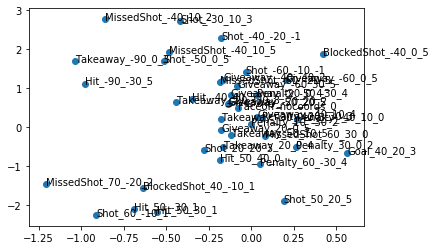

In [17]:
pca = PCA(n_components=100)
result = pca.fit_transform(model[model.wv.vocab])
c1 = 1
c2 = 0
start_wordi = 2040
stop_wordi = 2080
plt.scatter(result[start_wordi:stop_wordi, c1], 
            result[start_wordi:stop_wordi, c2])
words = list(model.wv.vocab)
for i, word in enumerate(words[0:stop_wordi]):
    if i >= start_wordi:
        plt.annotate(word, xy=(result[i, c1], result[i, c2]))
plt.show()